In [1]:
#%pip install requests_html

In [2]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler
import requests
from requests_html import HTMLSession
from sklearn.model_selection import train_test_split

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [4]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers=ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [5]:
def calculate_percentage_increase(final_value, starting_value):
    return 100 * ((final_value - starting_value) / starting_value)

In [6]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(1)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(-1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [7]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(-1)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [8]:
def wavetrend_indicator(df):
    ap = (df['high'] + df['low'] + df['close']) / 3
    esa = talib.EMA(ap, 10)
    d = talib.EMA(np.abs(ap - esa), 10)
    ci = (ap - esa) / (0.015 * d)
    tci = talib.EMA(ci, 21)

    signals = []
    for i in range(0, len(tci)):
        if tci[i] > 60:
            signals.append(-1)
        elif tci[i] < -60:
            signals.append(1)
        else:
            signals.append(0)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [9]:
def produce_prediction(df, window):  
    prediction = (df.shift(window)['close'] <= df['close'])
    
    return prediction.astype(int)

In [10]:
def supertrend_indicator(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]

            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return final_lowerband, final_upperband

In [11]:
def rsi_indicator(df):
    rsi = talib.RSI(df.close, 14)

    signals = []
    for i in range(0, len(rsi)):
        if rsi[i] > 70:
            signals.append(-1)
        elif rsi[i] < 30:
            signals.append(1)
        else:
            signals.append(0)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [12]:
def preprocess_data(df):
    scaler = MinMaxScaler()
    
    mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
    all_ssl_signals, _, _ = ssl_indicator(df=df)
    all_bbands_signals, _, _ = bbands_indicator(df=df)
    close_b = produce_prediction(df, 1)
    wavetrend_signals, _, _ = wavetrend_indicator(df)
    rsi_signals, _, _ = rsi_indicator(df)

    final_lowerband, final_upperband = supertrend_indicator(df, 10, 3)
    fu_modified = [1 if not np.isnan(lowerband) else 0 for lowerband in final_lowerband]
    fl_modified = [-1 if not np.isnan(upperband) else 0 for upperband in final_upperband]
    final_supertrend_indicator = np.sum([fu_modified, fl_modified], axis=0)

    df['close_binary'] = close_b
    df['price_change_percentage'] = calculate_percentage_increase(df['close'], df['close'].shift())
    df['mfi'] = mfi_indicator
    df['ssl_markover'] = all_ssl_signals
    df['bbands'] = all_bbands_signals
    df['wavetrend_signals'] = wavetrend_signals
    df['supertrend'] = final_supertrend_indicator
    df['rsi_signals'] = rsi_signals
    df = df.drop(columns={"volume", "Adj Close", "open", "high", "low", "date"})
    df = df.dropna()
    
    close = df.close
    df.drop(columns={'close'}, inplace=True)
    t_df = scaler.fit_transform(df)
    t_df = pd.DataFrame(t_df, columns=df.columns)
    t_df['close'] = close.values
    
    return t_df

In [13]:
session = HTMLSession()
num_currencies=23
symbols_to_remove = ['USDT-USD', 'USDC-USD', 'XRP-USD', 'BUSD-USD', 'DAI-USD', 'SHIB-USD']
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
symbols_yf = df.Symbol.tolist()
for symbol in symbols_to_remove:
    symbols_yf.remove(symbol)
print(symbols_yf)

['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'STETH-USD', 'DOGE-USD', 'MATIC-USD', 'WTRX-USD', 'SOL-USD', 'TRX-USD', 'LTC-USD', 'DOT-USD', 'AVAX-USD', 'HEX-USD', 'WBTC-USD', 'LINK-USD', 'LEO-USD']


In [14]:
dataframes = []

for symbol in symbols_yf:
    df = getTickerData(symbol, '730d', '1h')
    df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
    dataframes.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [15]:
preprocessed_dataframes = []
for df in dataframes:
    p_df = preprocess_data(df)
    if p_df.shape[1] == 9:
        preprocessed_dataframes.append(preprocess_data(df))

In [16]:
training_data = []
testing_data = []
for df in preprocessed_dataframes:
    train, test = train_test_split(df, train_size=0.8, shuffle=False)
    training_data.append(train.dropna())
    testing_data.append(test.dropna())

In [17]:
amount_of_rows = 0
for df in training_data:
    print(df.shape)
    amount_of_rows += df.shape[0]
print(f'total rows of data - {amount_of_rows}')

(13791, 9)
(13791, 9)
(13796, 9)
(13792, 9)
(8891, 9)
(13792, 9)
(13797, 9)
(8412, 9)
(9907, 9)
(13792, 9)
(13792, 9)
(9907, 9)
(13793, 9)
(13795, 9)
(8951, 9)
(13792, 9)
(8951, 9)
total rows of data - 206742


In [18]:
testing_data[0]

,close_binary,price_change_percentage,mfi,ssl_markover,bbands,wavetrend_signals,supertrend,rsi_signals,close
13791,1.0,0.537788,0.834471,0.0,0.5,0.5,1.0,0.5,16872.027344
13792,0.0,0.530218,0.801654,1.0,0.5,0.5,1.0,0.5,16864.017578
13793,0.0,0.528332,0.726589,0.0,0.5,0.5,1.0,0.5,16851.927734
13794,0.0,0.530048,0.760360,0.5,0.5,0.5,1.0,0.5,16843.560547
13795,0.0,0.522769,0.733262,0.5,0.5,0.5,0.0,0.5,16819.458984
...,...,...,...,...,...,...,...,...,...
17234,1.0,0.543385,0.529123,0.5,0.5,0.5,0.0,0.5,26865.373047
17235,0.0,0.524427,0.538465,0.5,0.5,0.5,0.0,0.5,26832.648438
17236,0.0,0.532031,0.652282,0.5,0.5,0.5,0.0,0.5,26826.154297
17237,0.0,0.512025,0.640723,0.5,0.5,0.5,0.0,0.5,26750.769531


In [19]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [20]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df[0].shape[1]-1), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
        self.portfolio = 1
        
    def step(self, action):
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        reward, p, t = self.calculate_reward(action)
            
        if action != Positions.HOLD:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
            
        observation = self.get_observation()
        info = {'p': p, 't': t}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        self.portfolio = 1
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_df = random.randint(0, len(self.df) - 1)
            self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        return self.df[self.random_df].iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].drop('close', axis=1).values
    
    def final_render(self):
        final_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        
        winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(30,10))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return winrate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [21]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05

        if self.in_a_pos and action != Positions.HOLD:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change
            
            self.trading_positions+=1
            if reward > 0:
                self.profited_trading_positions+=1
            
            reward = total_profit
            
            if reward < 0:
                reward *= 1
            
        return reward, percentage, total_profit

In [41]:
env = Trading(testing_data, window_size=34, n_steps=200)
env = Monitor(env)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


PERCENTAGE 0.0
PERCENTAGE -0.4332910647910084
PERCENTAGE 0.1567272382525841
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -0.5153645586830624
PERCENTAGE -0.23172168215440117
PERCENTAGE 0.0
PERCENTAGE -0.35764280318266223
PERCENTAGE 0.0
PERCENTAGE 0.6811220788852221
PERCENTAGE 0.40083427105662
PERCENTAGE -0.8693099842486334
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE 2.1114218998289567
PERCENTAGE 0.0
PERCENTAGE -0.4427565046126199
PERCENTAGE 2.742545961575147
PERCENTAGE 0.0
PERCENTAGE 0.14609690451268456
PERCENTAGE -0.17476333833352908
PERCENTAGE 0.9253965264418227
PERCENTAGE 1.7037603546025368
PERCENTAGE 1.7412646562688598
PERCENTAGE 1.789596837071875
PERCENTAGE 0.0
PERCENTAGE 0.10262907442133208
PERCENTAGE 0.0
PERCENTAGE 1.3697683314809705
PERCENTAGE 0.0
PERCENTAGE -0.22968358160880054
PERCENTAGE 0.97128753465908
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -1.6995291917129076
PERCENTAGE 0.0
PERCENTAGE -0.8722550316626282
PERCENTAGE -0.7

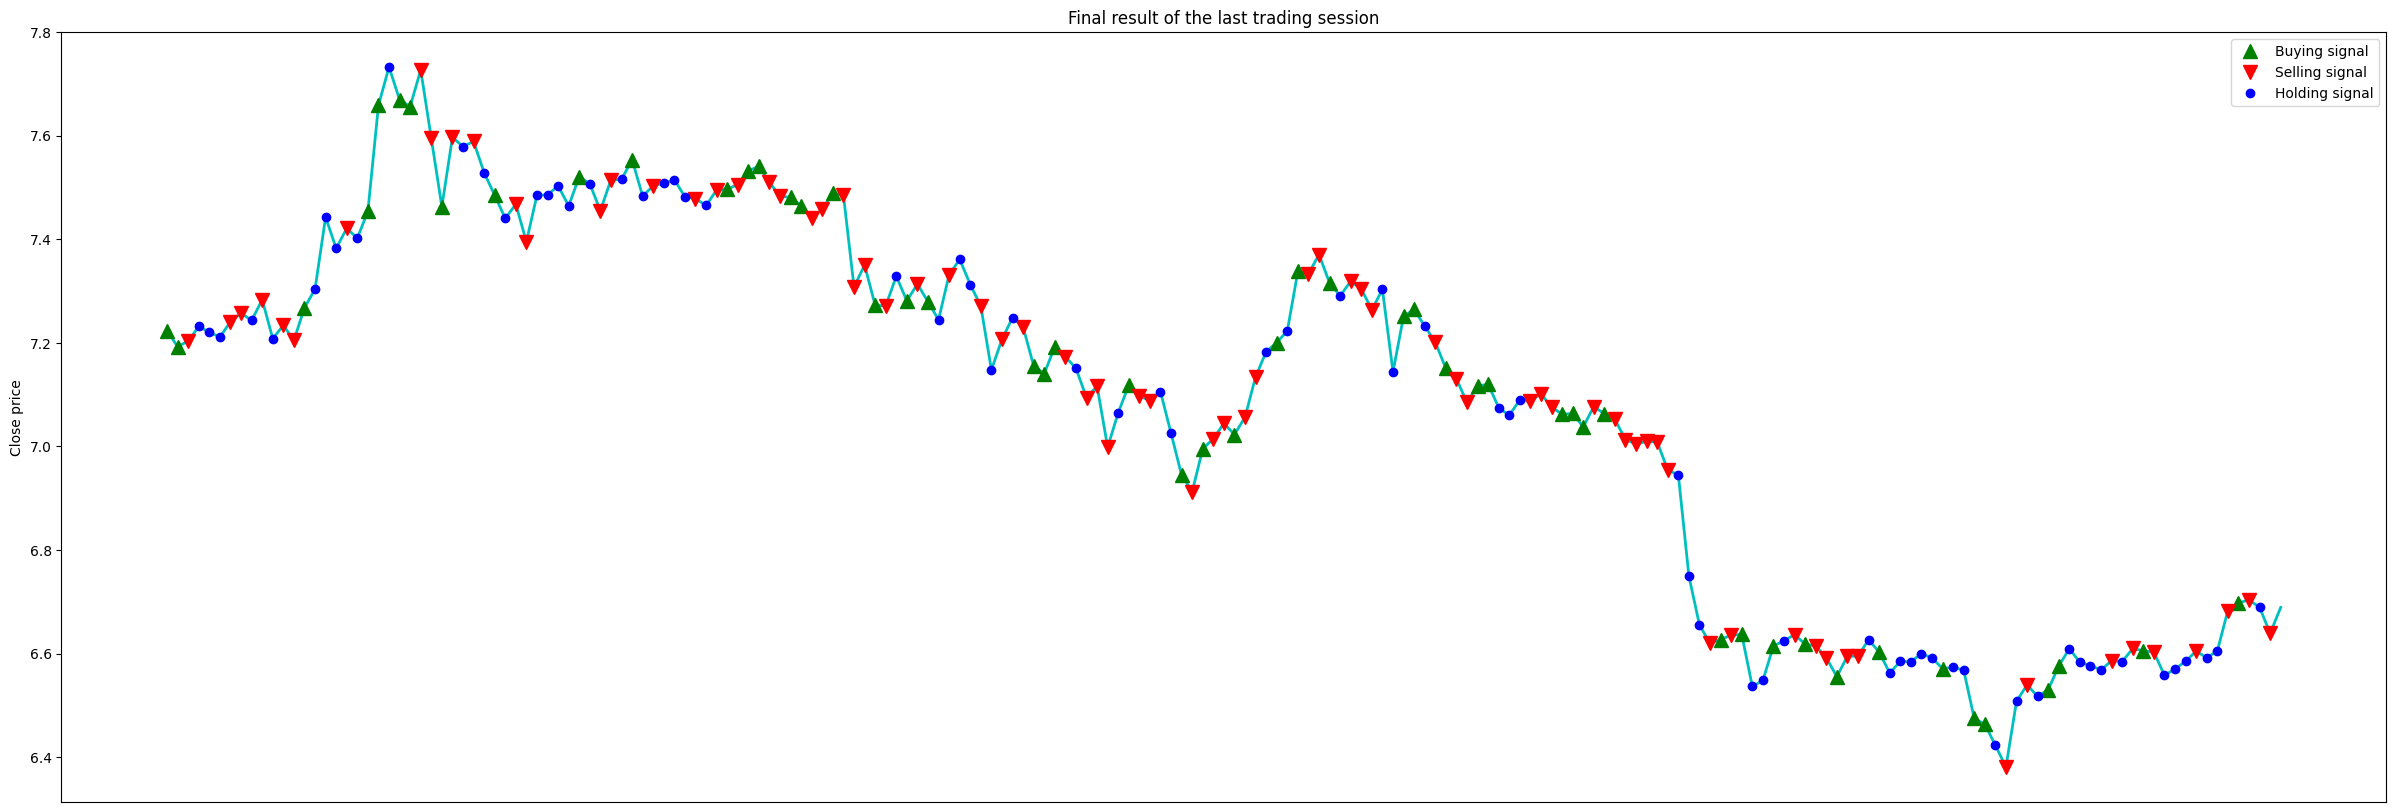

episode - 1 || score - 1.1291042292712756
0.0
1.1291042292712756


In [42]:
episodes = 1
for n in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        #print("REWARD", reward)
        #print('TOTAL_PROFIT', info['t'])
        print('PERCENTAGE', info['p'])
        total_profit_ += info["t"]
    winrate = env.final_render()
    print(f"episode - {n} || score - {score}")
    print(winrate)
    print(total_profit_)

In [24]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"
OPT_DIR = "./opt/"

In [25]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        "n_steps": trial.suggest_int("n_steps", 64, 8192),
        "gamma": trial.suggest_loguniform("gamma", 0.8, 0.9999),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "clip_range": trial.suggest_uniform("clip_range", 0.1, 0.4),
        "gae_lambda": trial.suggest_uniform("gae_lambda", 0.8, 0.99),
        "ent_coef": trial.suggest_uniform("ent_coef", 0.001, 0.01),
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [37]:
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=7917,
    gamma=0.8148319613766952,
    learning_rate=1.1494222672968137e-05,
    clip_range=0.11454224768088915,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
)

In [44]:
loaded_model = RecurrentPPO.load("./saved_models/best_model_4600000_nhai", env=env)

In [ ]:
opt_model = RecurrentPPO.load("./saved_models/opt_model_training_1", env=env)

In [38]:
loaded_model.learn(total_timesteps=500000, callback=callback)

In [40]:
evaluate_policy(model, env, n_eval_episodes=10)

(0.0, 0.0)

In [45]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

(0.2301861, 0.5519722619926567)

In [80]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-0.006837816031838884, 0.07551070536538326)

In [46]:
def test_portfolio(model, starting_money, amount_to_use, total_episodes_to_run = 1):
    all_portfolio_accumulation_results = []
    all_final_portfolio_value = []
    all_score = []
    win = 0
    
    for episode in range(1, total_episodes_to_run+1):
        obs = env.reset()
        done = False
        score = 0
        portfolio = starting_money
        portfolio_accumulation_results = []
        percentage_increase = 0
        total_profit = 0
    
        while not done:
            action, lstm_cells = model.predict(obs)
            obs, reward, done, info = env.step(action)
            score += reward
            percentage_increase = info['p']
        
            total_profit += ((starting_money * amount_to_use) * percentage_increase)
            portfolio_change = portfolio + ((starting_money * amount_to_use) * percentage_increase)
            portfolio = portfolio_change
            portfolio_accumulation_results.append(portfolio_change)
        
        all_portfolio_accumulation_results.append(portfolio_accumulation_results)
        all_final_portfolio_value.append(portfolio)
        all_score.append(score)
        if total_profit > 0:
            win += 1
        
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 7)
    for i in range(0, len(all_portfolio_accumulation_results)):
        ax.plot(all_portfolio_accumulation_results[i])
    env.final_render()
    
    print(f'avg score - {np.average(all_score)}')
    print(f'avg final portfolio value - {np.average(all_final_portfolio_value)}')
    print(f'winrate - {win / total_episodes_to_run}')

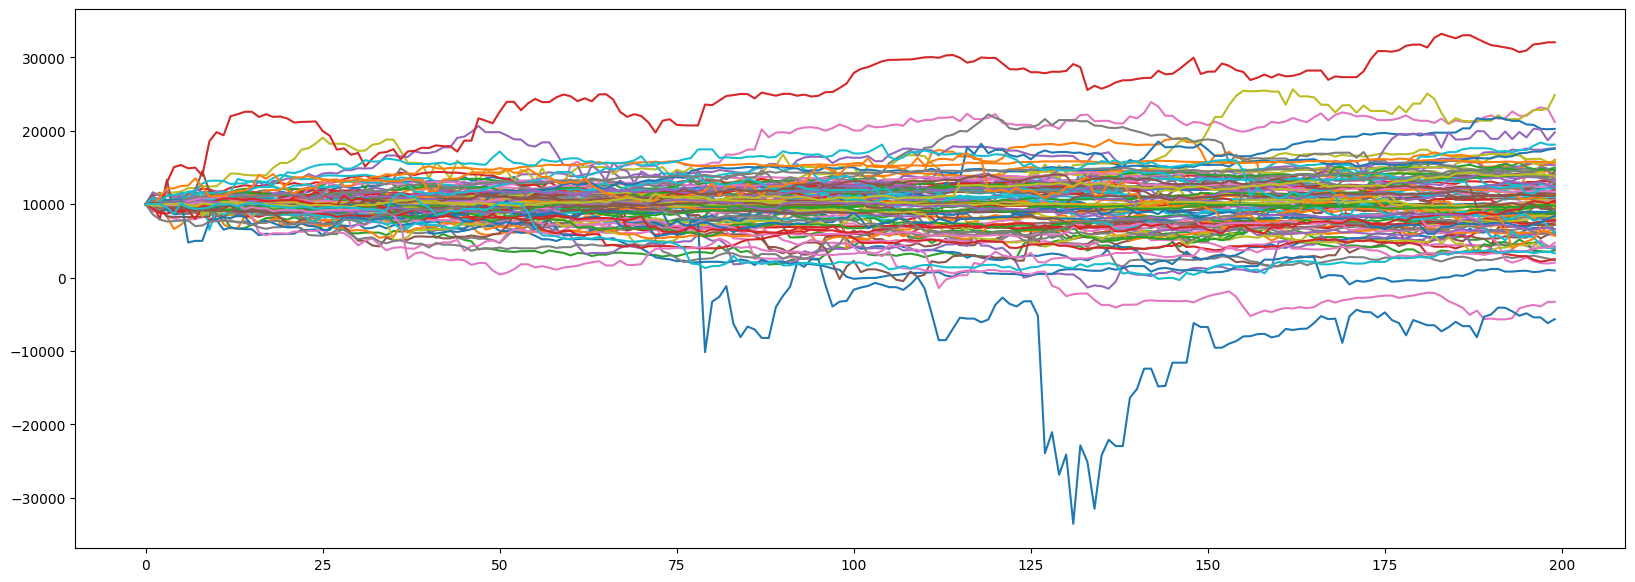

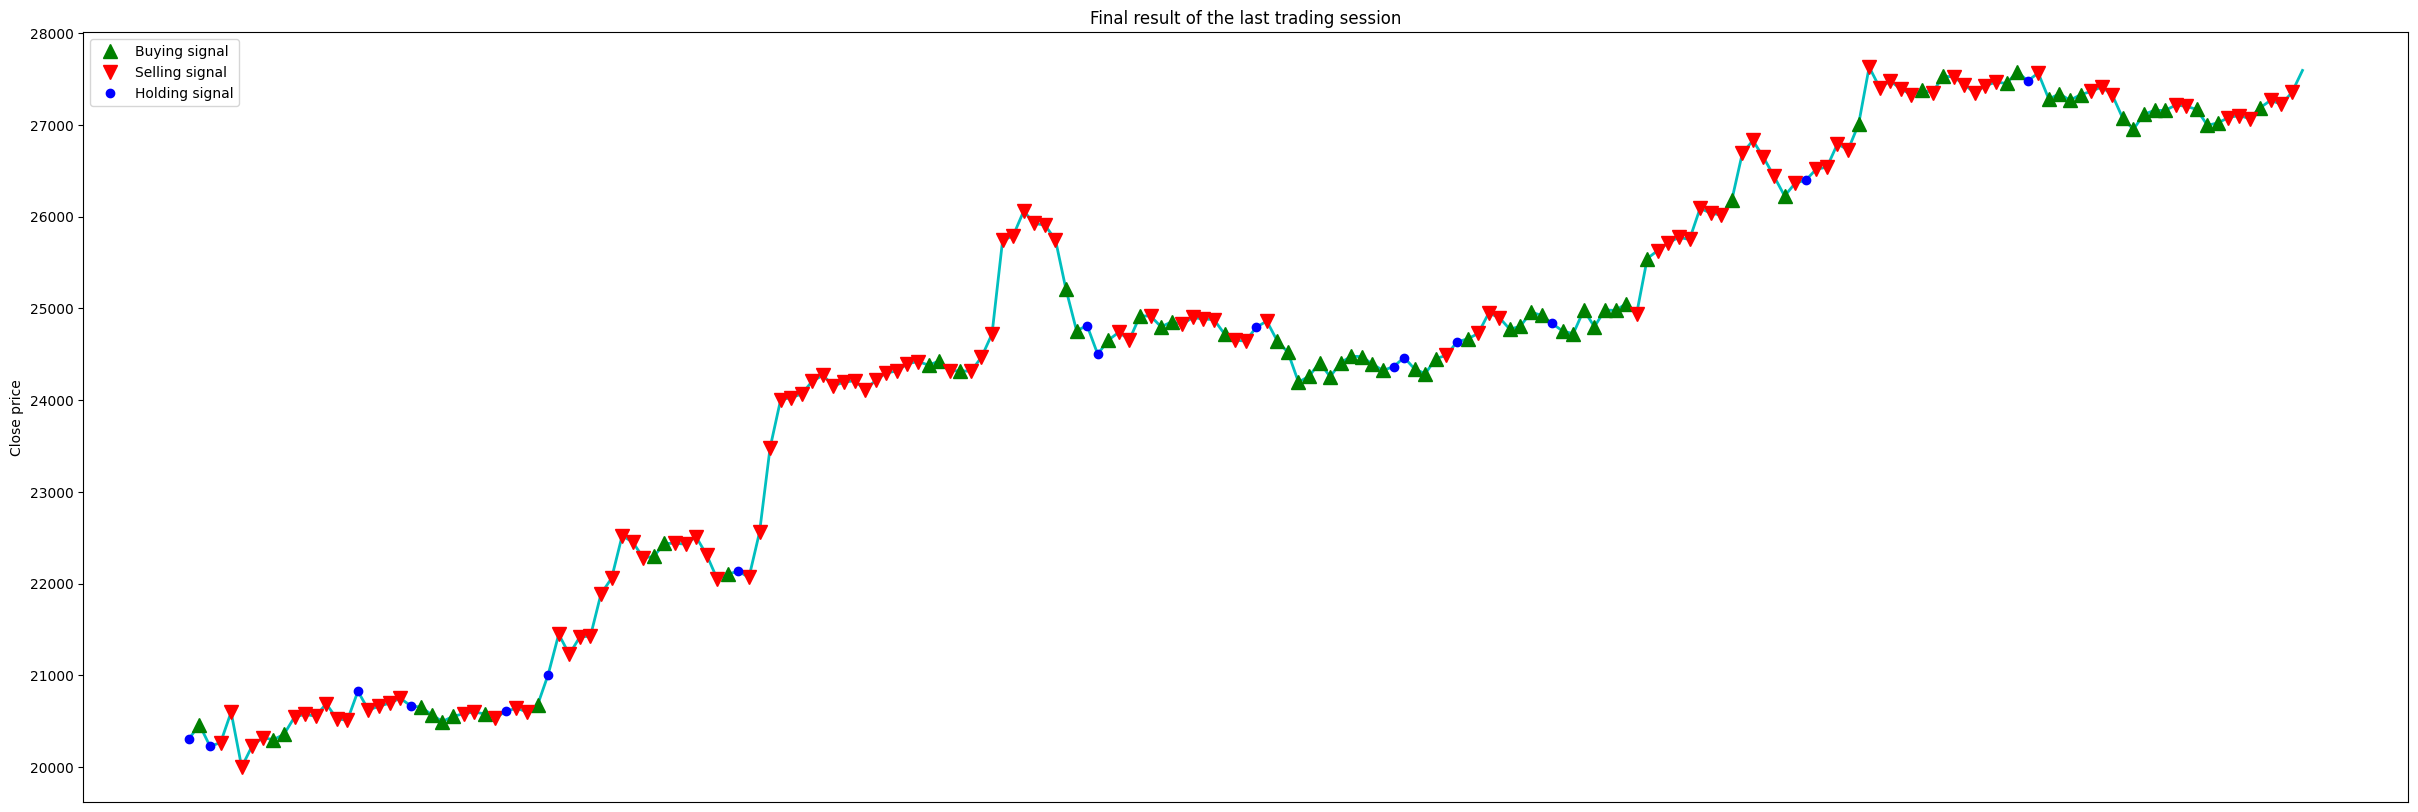

avg score - 0.00627065695479215
avg final portfolio value - 10365.560441241658
winrate - 0.52


In [47]:
test_portfolio(loaded_model, starting_money=10000, amount_to_use=0.05, total_episodes_to_run=100)